In [63]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [64]:
california_housing_dataframe = pd.read_csv('https://storage.googleapis.com/mledu-datasets/california_housing_train.csv', sep=',')

In [65]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe['median_house_value'] /= 1000

In [66]:
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
5228,-118.1,34.7,31.0,2666.0,662.0,1337.0,602.0,2.4,101.1
2089,-117.3,33.9,13.0,7910.0,1195.0,3382.0,1176.0,5.6,214.5
8362,-118.5,34.0,29.0,2329.0,833.0,1953.0,800.0,2.7,233.3
10502,-120.4,34.9,15.0,1534.0,251.0,761.0,240.0,4.9,193.6
3668,-117.9,33.8,35.0,1654.0,323.0,1065.0,354.0,3.5,186.5


In [67]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [68]:
my_feature = california_housing_dataframe[['total_rooms']]
feature_columns = [tf.feature_column.numeric_column('total_rooms')]

In [69]:
target = california_housing_dataframe['median_house_value']

In [70]:
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5)
linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=my_optimizer)

In [71]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features,labels

In [28]:
_=linear_regressor.train(max_steps=100, input_fn=lambda:my_input_fn(my_feature, target))

In [29]:
prediction_input_fn = lambda: my_input_fn(my_feature, target, 1, False, 1)
predictions = linear_regressor.predict(prediction_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])
mean_squared_error = metrics.mean_squared_error(predictions, target)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" ,mean_squared_error)
print( "Root Mean Squared Error (on training data): %0.3f" ,root_mean_squared_error)

Mean Squared Error (on training data): %0.3f 56367.02471115872
Root Mean Squared Error (on training data): %0.3f 237.41740608295493


In [30]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print ("Min. Median House Value: %0.3f" ,min_house_value)
print ("Max. Median House Value: %0.3f" ,max_house_value)
print ("Difference between Min. and Max.: %0.3f" ,min_max_difference)
print ("Root Mean Squared Error: %0.3f" ,root_mean_squared_error)

Min. Median House Value: %0.3f 14.999
Max. Median House Value: %0.3f 500.001
Difference between Min. and Max.: %0.3f 485.00199999999995
Root Mean Squared Error: %0.3f 237.41740608295493


In [31]:
calibration_data = pd.DataFrame()
calibration_data['predictions'] = pd.Series(predictions)
calibration_data['targets'] = pd.Series(target)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


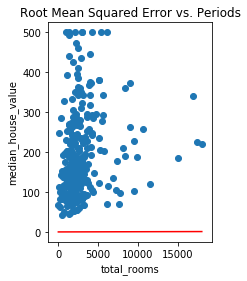

In [32]:
sample = california_housing_dataframe.sample(n=300)
x_0 = sample['total_rooms'].min()
x_1 = sample['total_rooms'].max()
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias
plt.plot([x_0, x_1], [y_0,y_1], c='r')
plt.ylabel('median_house_value')
plt.xlabel('total_rooms')
plt.scatter(sample['total_rooms'], sample['median_house_value'])
plt.show()

In [73]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print( "Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print( "  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print( "Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print ("Final RMSE (on training data): %0.2f" , root_mean_squared_error)
    
train_model(learning_rate=0.00001, steps=100, batch_size=1)

Training model...
RMSE (on training data):
  period 00 : 236.32
  period 01 : 235.11
  period 02 : 233.90
  period 03 : 232.70
  period 04 : 231.50
  period 05 : 230.31
  period 06 : 229.13
  period 07 : 227.96
  period 08 : 226.79
  period 09 : 225.63
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


Final RMSE (on training data): %0.2f 225.6260893480726


In [75]:
train_model(learning_rate=0.0001, steps=500,batch_size=1)

Training model...
RMSE (on training data):
  period 00 : 187.86
  period 01 : 166.74
  period 02 : 170.92
  period 03 : 171.74
  period 04 : 176.79
  period 05 : 179.23
  period 06 : 189.49
  period 07 : 191.15
  period 08 : 187.87
  period 09 : 192.86
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,206.2,207.3
std,170.0,116.0
min,0.2,15.0
25%,114.0,119.4
50%,165.9,180.4
75%,245.8,265.0
max,2959.1,500.0


Final RMSE (on training data): %0.2f 192.86444278449517
